In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from data import DataProvider

In [2]:
provider = DataProvider()
raw_df = provider.read_excel()
scaled_df = provider.scale_data(raw_df)

C:\Users\dimaherez\AppData\Local\Temp\ipykernel_14880\3921685181.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


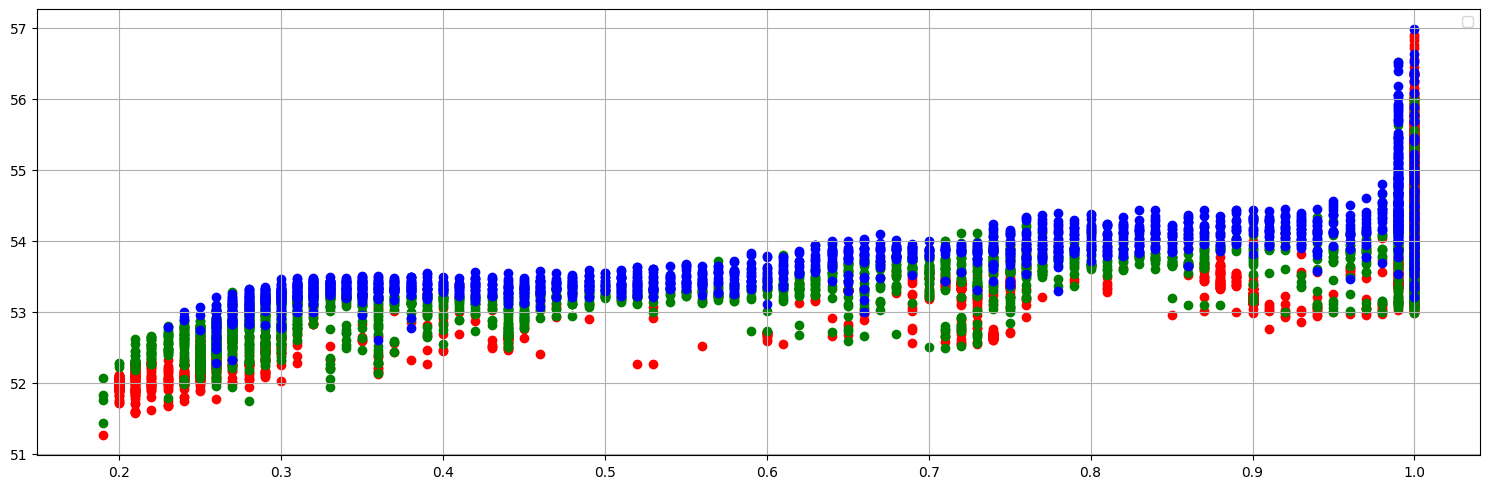

In [3]:
charging_df_0_2 = provider.get_charging_data(scaled_df, 0, -2)
charging_df_2_8 = provider.get_charging_data(scaled_df, -2, -8)
charging_df_8_14 = provider.get_charging_data(scaled_df, -8, -14)

charging_dfs = [charging_df_0_2, charging_df_2_8, charging_df_8_14]
rangesStrings = ["0A - 2A", "2A - 8A", "8A - 14A"]

plt.figure(figsize=(15, 5))

plt.scatter(
        charging_df_0_2["SoC"], 
        charging_df_0_2["Battery Voltage(V)"], 
        marker='o',  
        color='red'
    )

plt.scatter(
        charging_df_2_8["SoC"], 
        charging_df_2_8["Battery Voltage(V)"], 
        marker='o',  
        color='green'
    )

plt.scatter(
        charging_df_8_14["SoC"], 
        charging_df_8_14["Battery Voltage(V)"], 
        marker='o',  
        color='blue'
    )

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def build_model(input_dim, hidden_layers, activation='relu', output_activation=None):
    model = Sequential()
    
    # Add hidden layers
    for units in hidden_layers:
        model.add(Dense(units, activation=activation, input_shape=(input_dim,)))
        input_dim = None  # Only needed for first layer
    
    # Output layer
    model.add(Dense(1, activation=output_activation))  # For regression, use None or 'linear'
    
    return model

# Leaky ReLU model (requires custom layer)
def build_leaky_model(input_dim):
    model = Sequential([
        Dense(32, input_shape=(input_dim,)),
        LeakyReLU(alpha=0.01),
        Dense(16),
        LeakyReLU(alpha=0.01),
        Dense(1)
    ])
    return model

models = {
    "ReLU": lambda dim: build_model(dim, [32, 16], activation='relu'),
    "Tanh": lambda dim: build_model(dim, [32, 16], activation='tanh'),
    "Swish": lambda dim: build_model(dim, [32, 16], activation='swish'),
    "GELU": lambda dim: build_model(dim, [32, 16], activation=gelu),
    "LeakyReLU": build_leaky_model
}


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [5]:
benchmark_results = {}

for i, df in enumerate(charging_dfs):
    print(f"\n⚡ Charging Range {i+1}: Current ∈ {df['Battery Current(A)'].min():.1f} to {df['Battery Current(A)'].max():.1f} A")

    # Prepare data
    X = df[["SoC"]].values
    y = df["Battery Voltage(V)"].values.reshape(-1, 1)

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

    # Train each model
    for name, builder in models.items():
        model = builder(X_train.shape[1])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1, verbose=0)

        y_pred_scaled = model.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
        y_true = y_scaler.inverse_transform(y_test)

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        key = f"{rangesStrings[i]}_{name}"
        benchmark_results[key] = {
            "model": model,
            "mse": mse,
            "mae": mae,
            "r2": r2,
            "x": X_test,
            "y_pred": y_pred,
            "y_true": y_true
        }

c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



⚡ Charging Range 1: Current ∈ -2.0 to 0.0 A
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

⚡ Charging Range 2: Current ∈ -8.0 to -2.0 A


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

⚡ Charging Range 3: Current ∈ -14.0 to -8.0 A


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Method: 0A - 2A_ReLU
MSE: 0.2944
MAE: 0.4192
R2: 0.6354


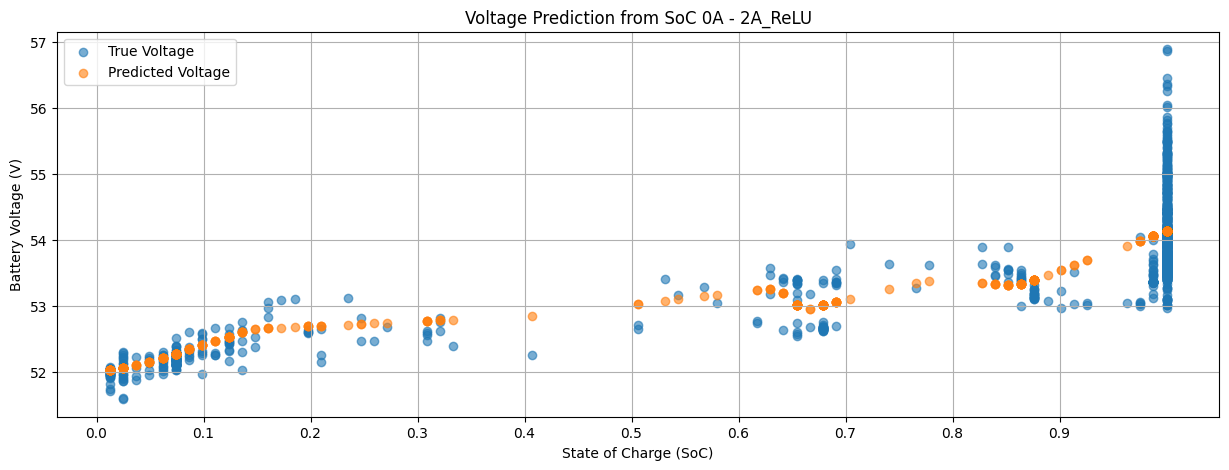

Method: 0A - 2A_Tanh
MSE: 0.3060
MAE: 0.4109
R2: 0.6211


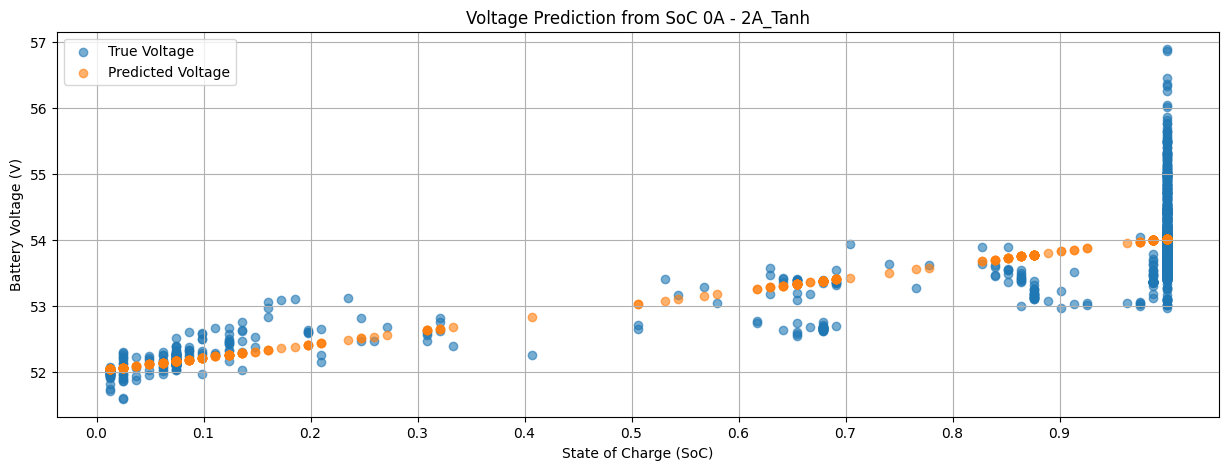

Method: 0A - 2A_Swish
MSE: 0.2971
MAE: 0.4043
R2: 0.6321


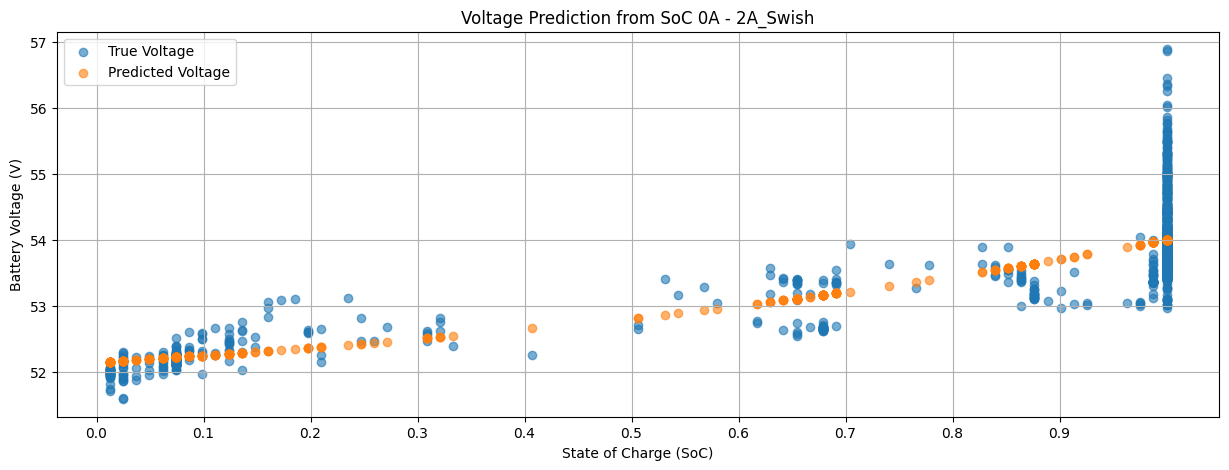

Method: 0A - 2A_GELU
MSE: 0.2959
MAE: 0.4055
R2: 0.6336


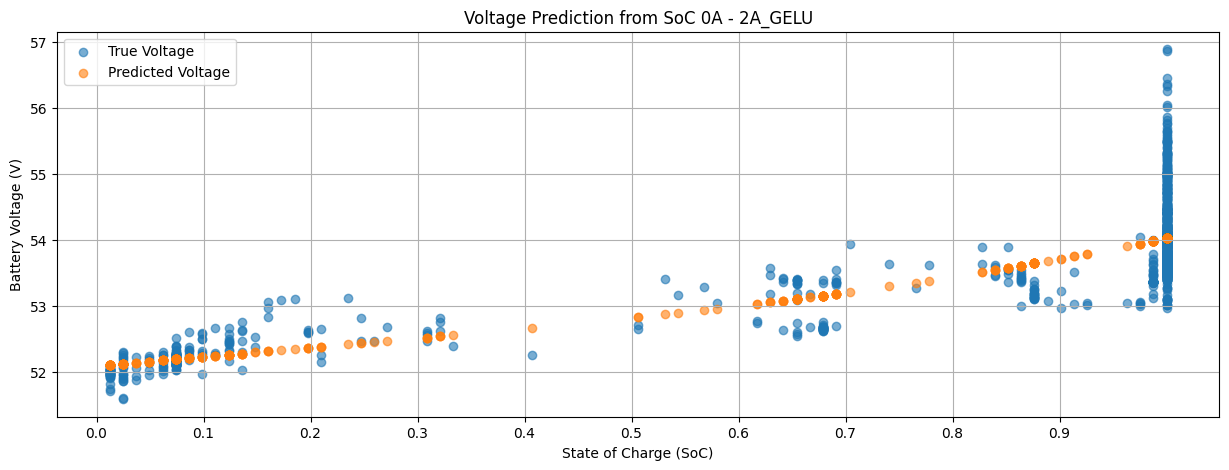

Method: 0A - 2A_LeakyReLU
MSE: 0.2851
MAE: 0.3882
R2: 0.6469


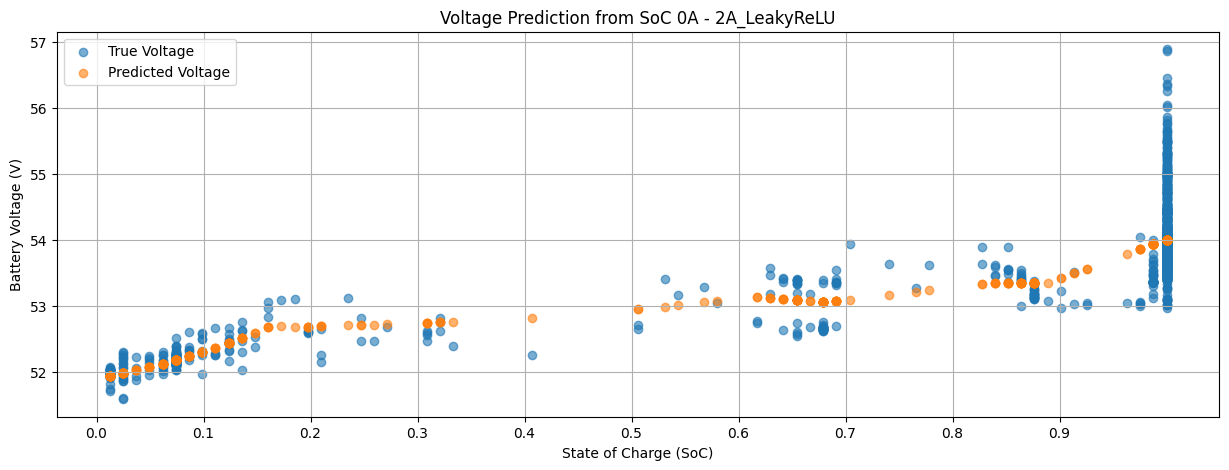

Method: 2A - 8A_ReLU
MSE: 0.1101
MAE: 0.2344
R2: 0.6896


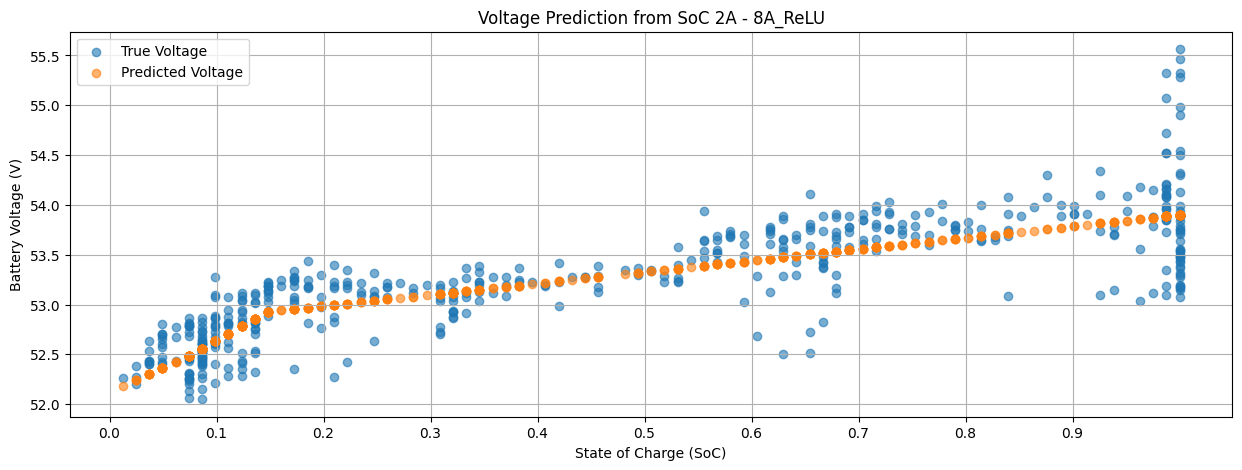

Method: 2A - 8A_Tanh
MSE: 0.1143
MAE: 0.2388
R2: 0.6776


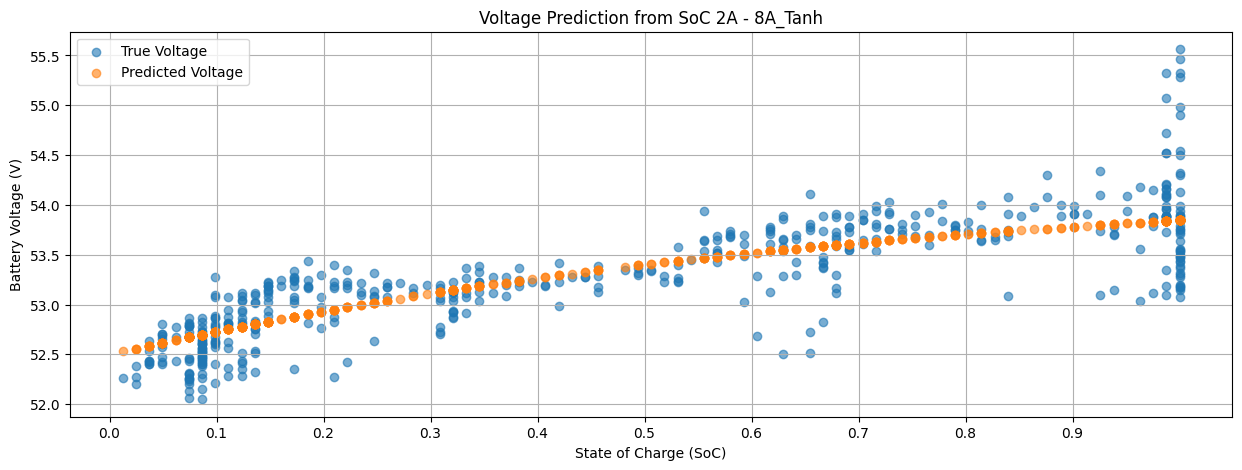

Method: 2A - 8A_Swish
MSE: 0.1124
MAE: 0.2349
R2: 0.6832


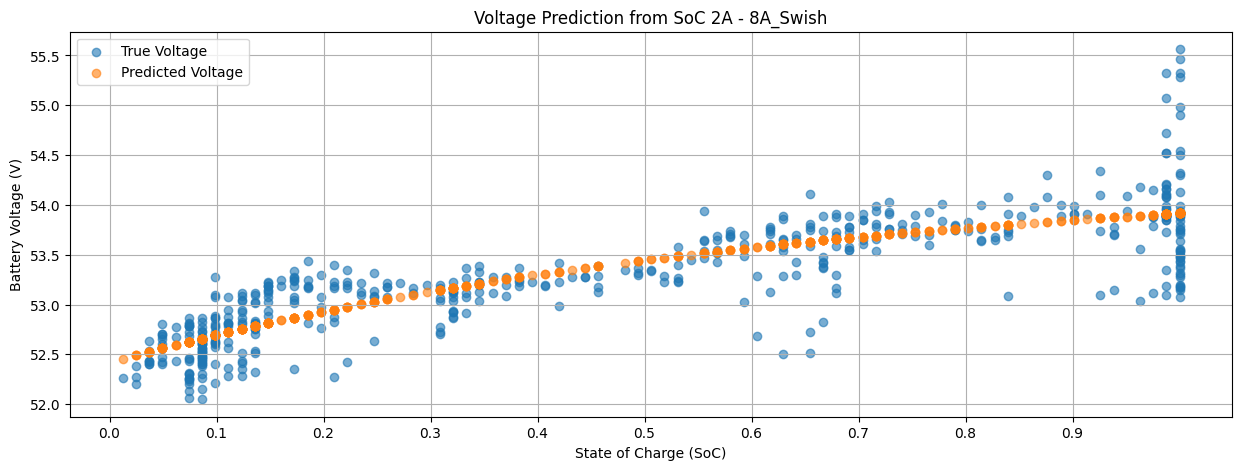

Method: 2A - 8A_GELU
MSE: 0.1118
MAE: 0.2323
R2: 0.6849


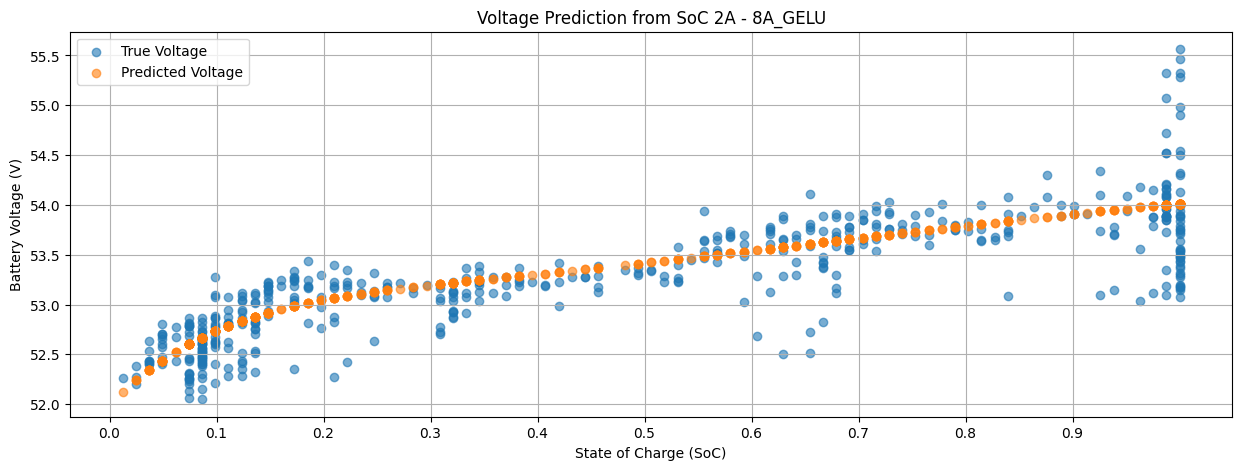

Method: 2A - 8A_LeakyReLU
MSE: 0.1066
MAE: 0.2238
R2: 0.6993


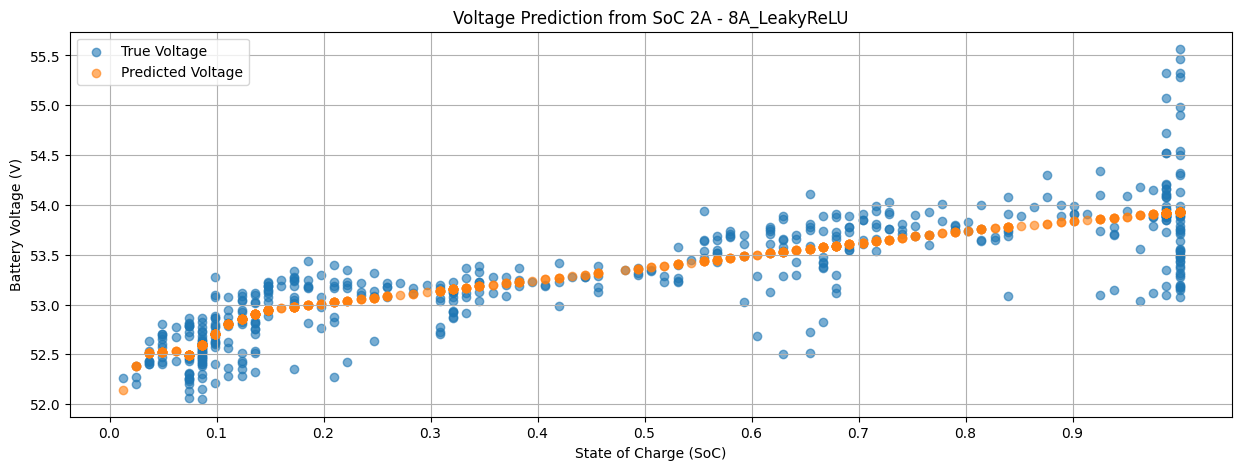

Method: 8A - 14A_ReLU
MSE: 0.1037
MAE: 0.1978
R2: 0.6985


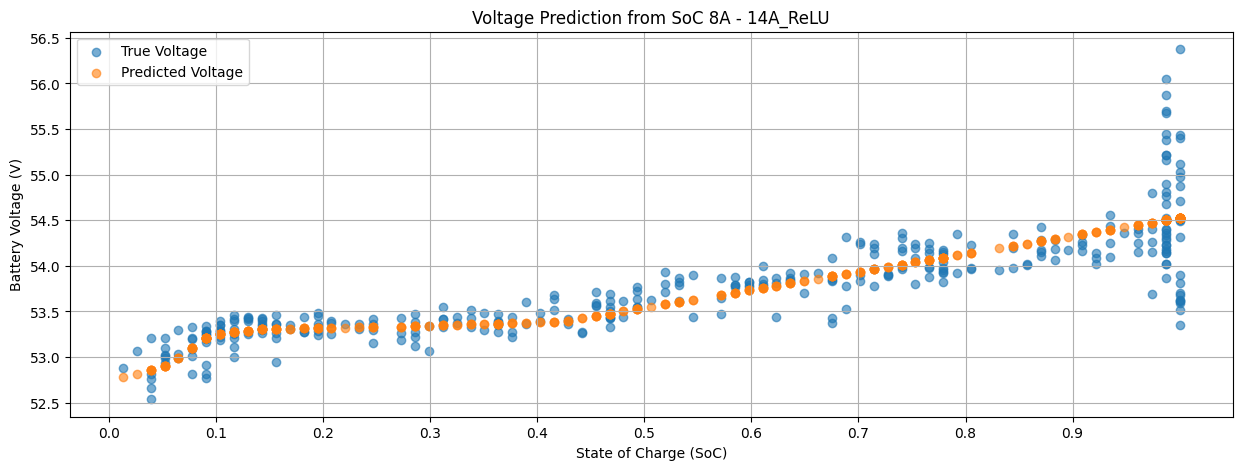

Method: 8A - 14A_Tanh
MSE: 0.1122
MAE: 0.2168
R2: 0.6736


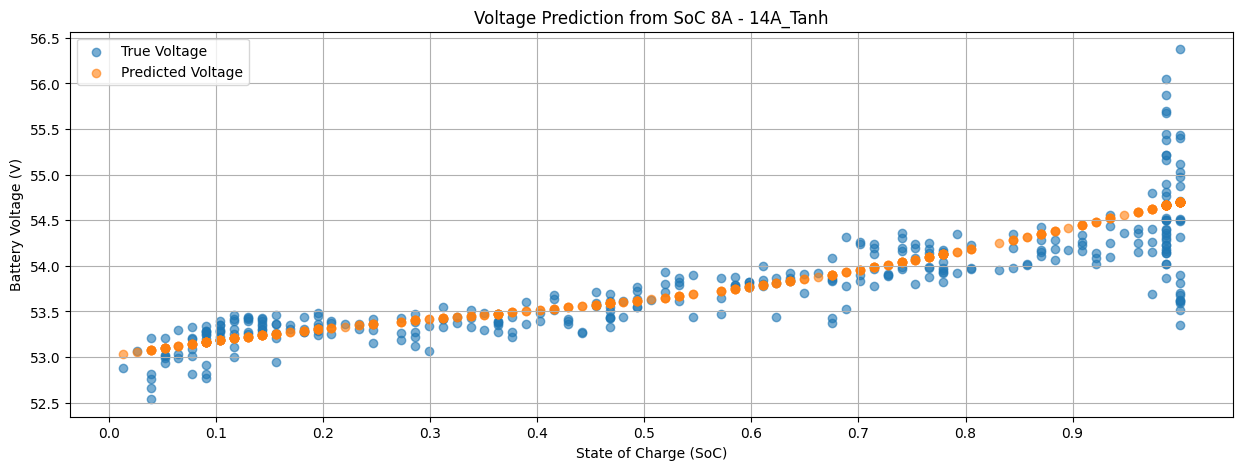

Method: 8A - 14A_Swish
MSE: 0.1106
MAE: 0.2167
R2: 0.6783


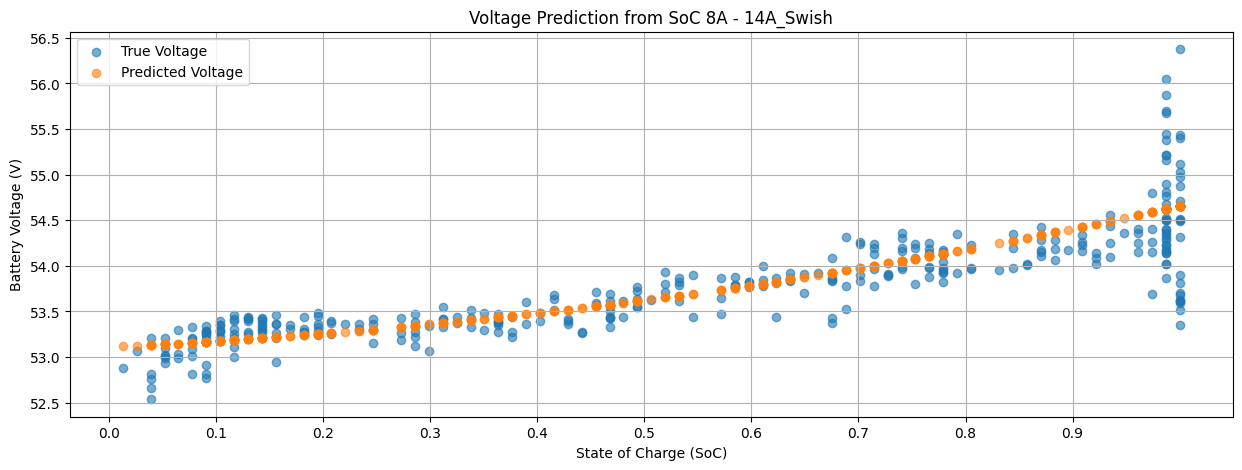

Method: 8A - 14A_GELU
MSE: 0.1065
MAE: 0.2082
R2: 0.6904


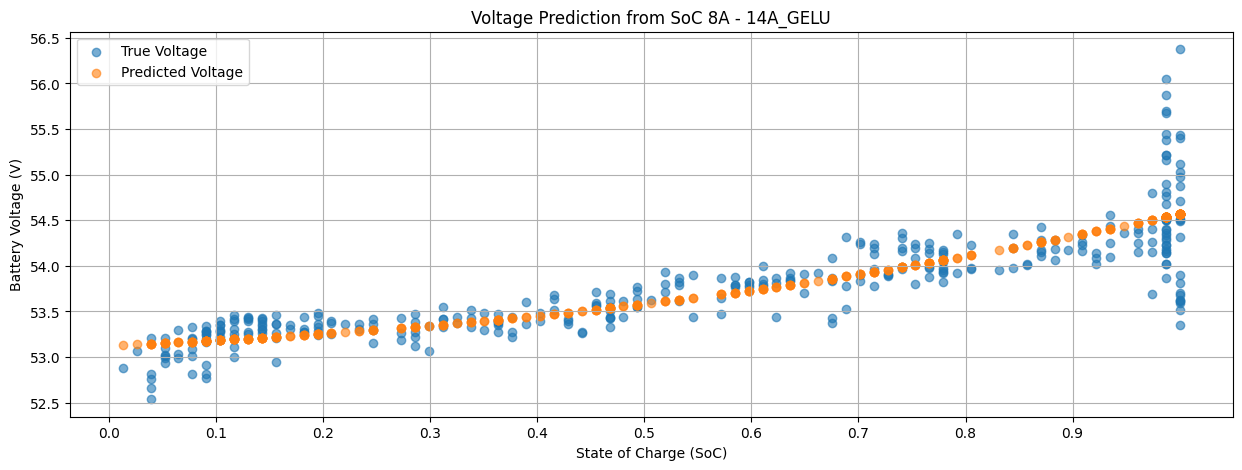

Method: 8A - 14A_LeakyReLU
MSE: 0.1052
MAE: 0.1989
R2: 0.6941


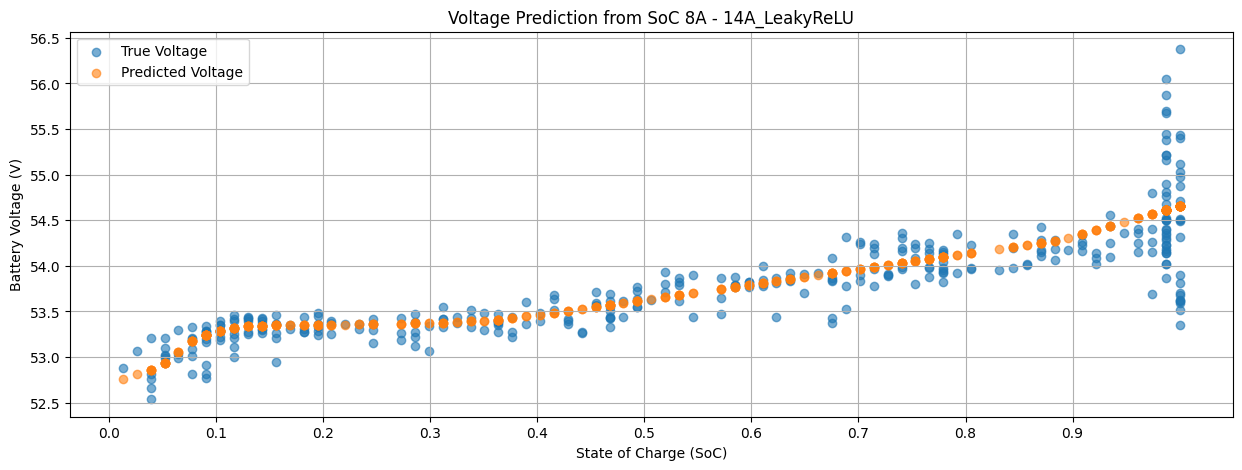

In [8]:
for key in benchmark_results:
    print(f"Method: {key}")
    print(f"MSE: {benchmark_results[key]["mse"]:.4f}")
    print(f"MAE: {benchmark_results[key]["mae"]:.4f}")
    print(f"R2: {benchmark_results[key]["r2"]:.4f}")

    plt.figure(figsize=(15, 5))    
    plt.scatter(benchmark_results[key]["x"], benchmark_results[key]["y_true"], label='True Voltage', alpha=0.6)
    plt.scatter(benchmark_results[key]["x"], benchmark_results[key]["y_pred"], label='Predicted Voltage', alpha=0.6)
    plt.xlabel("State of Charge (SoC)")
    plt.ylabel("Battery Voltage (V)")
    plt.xticks(np.arange(0, 1, 0.1))
    plt.legend()
    plt.title(f"Voltage Prediction from SoC {key}")
    plt.grid(True)
    plt.show()

In [9]:
# for df in charging_dfs:
#     X = df[["SoC"]].values  # Input: SoC
#     y = df["Battery Voltage(V)"].values.reshape(-1, 1)  # Target: Voltage

#     # Normalize
#     x_scaler = MinMaxScaler()
#     y_scaler = MinMaxScaler()

#     X_scaled = x_scaler.fit_transform(X)
#     y_scaled = y_scaler.fit_transform(y)

#     # Train/test split
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

#     # Train
#     model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1, callbacks=[early_stop])

#     # Evaluate
#     results = model.evaluate(X_test, y_test)
#     print(f"Loss (MSE): {results[0]:.4f}")
#     print(f"MAE: {results[1]:.4f}")
#     print(f"MSE: {results[2]:.4f}")
#     print(f"R² Score: {results[3]:.4f}")


#     # Predict on test set
#     x = np.arange(0, 1.0, 0.01).reshape(-1, 1)
#     y_pred_scaled = model.predict(x)
#     y_pred = y_scaler.inverse_transform(y_pred_scaled)

#     # Compare predictions

#     df_smoothed = provider.get_smoothed_data(df)

#     plt.figure(figsize=(15, 5))
#     plt.scatter(df_smoothed['SoC'], df_smoothed['Battery Voltage(V)'], label='True Voltage', alpha=0.6)
#     plt.scatter(x_scaler.inverse_transform(x), y_pred, label='Predicted Voltage', alpha=0.6)
#     plt.xlabel("State of Charge (SoC)")
#     plt.ylabel("Battery Voltage (V)")
#     plt.xticks(np.arange(0, 1, 0.1))
#     plt.legend()
#     plt.title("Voltage Prediction from SoC")
#     plt.grid(True)
#     plt.show()